# **Experiment 2**

In [10]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import shutil
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3

In [2]:
from google.colab import drive
drive.mount('/content/new_drive')

Mounted at /content/new_drive


In [3]:
source_dir = "/content/new_drive/MyDrive/Colab Notebooks/thermal images UL"
output_dir = "/content/new_drive/MyDrive/Colab Notebooks/thermal images UL"

classes = ['Blast', 'BLB', 'healthy', 'hispa', 'leaf folder', 'leaf spot']


In [4]:
# Step 1: Data Preparation
def prepare_data(source_dir, output_dir, classes, test_size=0.2, val_size=0.2):
    """Prepare the dataset by splitting it into training, validation, and test sets."""
    splits = ['train', 'validation', 'test']

    # Create directories for splits
    for split in splits:
        for cls in classes:
            os.makedirs(os.path.join(output_dir, split, cls), exist_ok=True)

    # List all images and split data
    for cls in classes:
        class_dir = os.path.join(source_dir, cls)
        images = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.endswith(('jpg', 'png'))]

        # Split into train, validation, and test sets
        train_val_images, test_images = train_test_split(images, test_size=test_size, random_state=42)
        train_images, val_images = train_test_split(train_val_images, test_size=val_size, random_state=42)

        # Copy images to respective directories
        for img_path in train_images:
            shutil.copy(img_path, os.path.join(output_dir, 'train', cls))
        for img_path in val_images:
            shutil.copy(img_path, os.path.join(output_dir, 'validation', cls))
        for img_path in test_images:
            shutil.copy(img_path, os.path.join(output_dir, 'test', cls))

    print("Dataset preparation complete.")

In [5]:
# Prepare dataset
prepare_data(source_dir, output_dir, classes)

Dataset preparation complete.


In [6]:
# Step 2: Create Data Generators
def create_data_generators(output_dir, img_size=(224, 224), batch_size=32):
    datagen_train = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    datagen_val_test = ImageDataGenerator(rescale=1./255)

    train_generator = datagen_train.flow_from_directory(
        os.path.join(output_dir, 'train'),
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    val_generator = datagen_val_test.flow_from_directory(
        os.path.join(output_dir, 'validation'),
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_generator = datagen_val_test.flow_from_directory(
        os.path.join(output_dir, 'test'),
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    return train_generator, val_generator, test_generator

In [7]:
# Create data generators
train_gen, val_gen, test_gen = create_data_generators(output_dir)

Found 586 images belonging to 6 classes.
Found 317 images belonging to 6 classes.
Found 222 images belonging to 6 classes.


In [8]:
# Step 3: Build InceptionV3 Model
def build_inceptionv3_model(input_shape=(224, 224, 3), num_classes=6):
    """Build an InceptionV3 model for classification."""
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = True  # Fine-tune the pre-trained model

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [11]:
# Build the model
model = build_inceptionv3_model()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [12]:
# Step 4: Train the Model
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 470s 22s/step - accuracy: 0.2409 - loss: 1.8448 - val_accuracy: 0.4196 - val_loss: 1.4334 - learning_rate: 1.0000e-04
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 344s 18s/step - accuracy: 0.5354 - loss: 1.2219 - val_accuracy: 0.5394 - val_loss: 1.2872 - learning_rate: 1.0000e-04
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 341s 18s/step - accuracy: 0.6662 - loss: 0.8840 - val_accuracy: 0.5836 - val_loss: 1.1126 - learning_rate: 1.0000e-04
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 343s 18s/step - accuracy: 0.7831 - loss: 0.5891 - val_accuracy: 0.6120 - val_loss: 1.0277 - learning_rate: 1.0000e-04
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 338s 18s/step - accuracy: 0.8655 - loss: 0.3912 - val_accuracy: 0.6088 - val_loss: 1.0317 - learning_rate: 1.0000e-04
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 336s 18s/step - accuracy: 0.8895 - loss: 0.3256 - val_accuracy: 0.7508 - val_loss: 0.7192 - learning_rate: 1.0000e-04
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 337s 18s/step - accuracy: 

In [13]:
# Step 5: Evaluate the Model
eval_results = model.evaluate(test_gen)
print(f"Test Accuracy: {eval_results[1] * 100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - accuracy: 0.9061 - loss: 0.2460
Test Accuracy: 90.54%


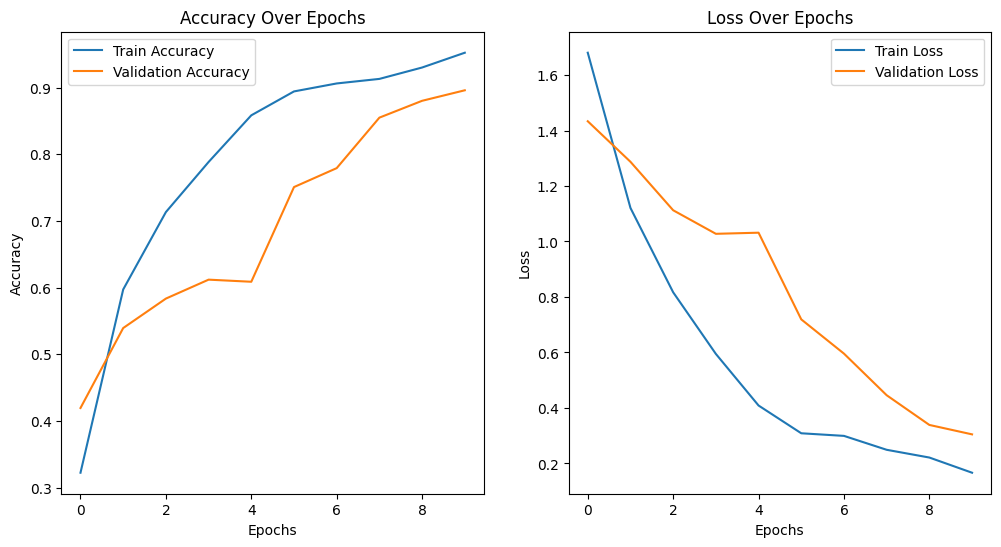

In [14]:
# Step 6: Plot Training and Validation Accuracy and Loss
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(history)

In [16]:
# Save the model
model.save("InceptionV3.h5")
print("Model saved.")

Model saved.
